# Predicting Properties of Quantum Systems with Conditional Generative Models

Tutorial by Maurice Weber, Xanadu Summer Resident, email: maurice.weber@inf.ethz.ch, Nov 2022

## Problem Setup
In this tutorial, we learn how conditional generative models can be used to predict properties of families of quantum states. As a specific example, we will consider the ground states of the 2D anti-ferromagnetic random Heisenberg model with Hamiltonian

$$
 H(\mathbf{x}) = \sum_{\langle ij \rangle} \mathbf{x}_{ij} (X_i X_j + Y_i Y_j + Z_i Z_j),
$$

where the sum is over nearest neighbours in a 2D lattice and $\mathbf{x} = (\mathbf{x}_{ij})_{i,j=1}^n$ is a coupling matrix containing the coupling strengths between different sites. For a POVM $\mathcal{M}$, the goal is to train a generative model $p_\theta$ such that

$$
    p_\theta(a_1,\,\ldots,\,a_n~\lvert~\mathbf{x}) = \langle \psi_{\mathbf x}\rvert M_{\vec a}\lvert \psi_{\mathbf x} \rangle ~~~~ M_{\vec a} \in \mathcal{M},
$$

where $\lvert \psi_{\mathbf x} \rangle$ denotes the ground state of the Hamiltonian $H(\mathbf x)$, and the vector $\vec a = (a_1,~\ldots,~a_n)^T$ contains the measurement outcomes. Here we consider the Pauli-6 POVM, which is given by the set of operators

$$
    \mathcal{M}_{\text{Pauli-6}}^{\otimes n} = \left\{
        \frac{1}{3}\lvert{+}\rangle\langle{+}\rvert,\,
        \frac{1}{3}\lvert{-}\rangle\langle{-}\rvert,\,
        \frac{1}{3}\lvert{l}\rangle\langle{l}\rvert,\,
        \frac{1}{3}\lvert{r}\rangle\langle{r}\rvert,\,
        \frac{1}{3}\lvert{0}\rangle\langle{0}\rvert,\,
        \frac{1}{3}\lvert{1}\rangle\langle{1}\rvert
    \right\}^{\otimes n}
$$

so that measurement outcomes take values $\vec a \in \{+,~-,~l,~r,~0,~1\}^n$. To predict properties of the ground state $\lvert \psi_{\mathbf x} \rangle$, we make use of classical shadows. In the following we briefly outline how classical shadows can be used to estimate local observables and subsystem entanglement entropies.

### Post-Processing using Classical Shadows

Classical shadows provide a way to estimate properties of a quantum state $\rho$, given a collection of Pauli-6 measurements.
Given $T$ measurement shots for the Pauli-6 POVM, the classical shadow of an arbitrary state $\rho$ is given by the collection of snapshots

$$
    \texttt{S}(\rho;~T) = \left\{\hat\rho^{(1)}:=\bigotimes_{i=1}^n\left(3 \lvert a_i^{(1)}\rangle\langle a_i^{(1)}\rvert - \mathbb{1}_2\right),~\ldots,~\hat\rho^{(T)}:=\bigotimes_{i=1}^n\left(3 \lvert a_i^{(T)}\rangle\langle a_i^{(T)}\rvert - \mathbb{1}_2\right)\right\}.
$$

This collection allows one to reconstruct the density matrix of $\rho$ in expectation

$$
    \hat\rho_T := \frac{1}{T}\sum_{t=1}^T \bigotimes_{i=1}^n\left(3 \lvert a_i^{(t)}\rangle\langle a_i^{(t)}\rvert - \mathbb{1}_2\right) \xrightarrow{T\to\infty} \mathbb{E}_{\vec a}\left[\bigotimes_{i=1}^n\left(3 \lvert a_i^{(t)}\rangle\langle a_i^{(t)}\rvert - \mathbb{1}_2\right)\right] = \rho
$$

or directly estimate obervables. Specifically, to estimate Pauli observables $P = P_1\otimes\ldots\otimes P_n$, with $P_i\in\{\mathbb{1},\,X,\,Y,\,Z\}$, we use the identity

$$
    \mathrm{Tr}\left[P\hat\rho\right] = \frac{1}{T}\sum_{t=1}^T \prod_{i=1}^n \left(3\langle a_i^{(t)}\rvert P_j\lvert a_i^{(t)}\rangle - \mathrm{Tr}[P_i]\right).
$$

Another important property that we will estimate using classical shadows is the second-order Rényi subsystem entanglement entropy $\mathcal{S}(\rho_A) = -\ln \mathrm{Tr}[\rho_A^2]$ where $\rho_A$ is the reduced density matrix for subsystem $A$. For two sites $i\neq j$, we can approximate $\mathcal{S}(\rho_A)$ using the identity

$$
    \mathrm{Tr}\left[\hat\rho_{\{ij\}}^2\right] = \frac{1}{T^2}\sum_{t,~s=1}^T \left(9\lvert\langle a_i^{(t)}|a_i^{(s)}\rangle\rvert^2 - 4\right)\cdot\left(9\lvert\langle a_j^{(t)}|a_j^{(s)}\rangle\rvert^2 - 4\right).
$$

For further details about classical shadows, visit the two Pennylane tutorials: 
- [Tutorial on Classical Shadows](https://pennylane.ai/qml/demos/tutorial_classical_shadows.html): A Python re-implementation of Hsin-Yuan Huang's [_classical shadows code (C++)_](https://github.com/hsinyuan-huang/predicting-quantum-properties),
- [Machine learning for quantum many-body problems](https://pennylane.ai/qml/demos/tutorial_ml_classical_shadows.html): A Python implementation of [_Provably efficient machine learning for quantum many-body problems_](https://arxiv.org/abs/2106.12627).

# A closer look at the 2D Heisenberg Model

Here, we want to investigate the ground states of the 2D random Heisenber model. Specifically, here we compute 2-point correlation functions and subsystem entanglement entropies. These evaluations will later serve us a point of reference for the predictions made by our conditional generative model. Let us start by making some basic imports:

In [1]:
import itertools as it
from matplotlib import gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pennylane as qml
import qutip
import scipy as sp
from tqdm.auto import tqdm

/home_new/tangyehui/miniconda3/envs/gqs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rng = np.random.default_rng()

We first setup a function which generates a 2D lattice connection weights sampled uniformly at random from the interval $[0,~2]$:

In [3]:
def sample_coupling_matrix(rows, cols):
    qubits = rows * cols
    
    # Create a 2D Lattice
    edges = [
        (si, sj) for (si, sj) in it.combinations(range(qubits), 2)
        if ((sj % cols > 0) and sj - si == 1) or sj - si == cols
    ]
    
    # sample edge weights uniformly at random from [0, 2]
    edge_weights = rng.uniform(0, 2, size=len(edges))
    
    coupling_matrix = np.zeros((qubits, qubits))
    for (i, j), w in zip(edges, edge_weights):
        coupling_matrix[i, j] = coupling_matrix[j, i] = w
        
    return coupling_matrix

In [4]:
# define the system size and lattice geometry
rows, cols = 4, 4
wires = rows * cols

# sample a coupling matrix
J = sample_coupling_matrix(rows, cols)

To get an intuition about how our system looks like, we visualize the coupling graph corresponding to our Hamiltonian usig the `networkx` library.

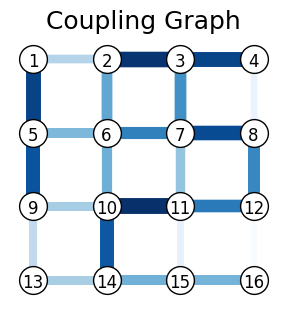

In [5]:
# create graph object
graph = nx.from_numpy_array(np.matrix(J), create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, {i: i + 1 for i in graph.nodes})
pos = {i: ((i-1) % cols, -((i-1) // cols)) for i in graph.nodes()}

# make edge widths proportional to edge weight
edge_widths = [
    (x + 1.5) ** 2 for x in list(nx.get_edge_attributes(graph, "weight").values())
]

# extract edge weights for colouring
edges, weights = zip(*nx.get_edge_attributes(graph,'weight').items())

plt.figure(figsize=(cols / 1.5, rows / 1.5))
nx.draw(
    graph, pos, node_color="white", with_labels=True, font_color="black", edge_cmap=plt.cm.Blues,
    node_size=400, width=edge_widths, horizontalalignment='center', edgecolors="black", edgelist=edges, 
    edge_color=weights, arrows=False, verticalalignment='center_baseline', font_size=12
)
plt.title('Coupling Graph', fontsize=18)
plt.show()

Given the coupling graph, we can now setup the corresponding Hamiltonian, compute its ground state using exact diagonalization and compute different properties of the system. Let us first write a function which sets up the Hamiltonian. 

In [6]:
def build_hamiltonian(coupling_matrix):
    coeffs, ops = [], []
    ns = coupling_matrix.shape[0]

    for i, j in it.combinations(range(ns), r=2):
        coeff = coupling_matrix[i, j]
        if coeff:
            for op in [qml.PauliX, qml.PauliY, qml.PauliZ]:
                coeffs.append(coeff)
                ops.append(op(i) @ op(j))

    return qml.Hamiltonian(coeffs, ops)

Next, we will compute its ground state with exact diagonalization and using a sparse representation of the Hamiltonian:

In [7]:
# build sparse hamiltonian
H = build_hamiltonian(J)
H_sparse = qml.utils.sparse_hamiltonian(H)

# diagonalize
eigvals, eigvecs = sp.sparse.linalg.eigs(H_sparse, which='SR', k=1)
eigvals = eigvals.real
ground_state = eigvecs[:, np.argmin(eigvals)]

/home_new/tangyehui/miniconda3/envs/gqs/lib/python3.9/site-packages/pennylane/utils.py:67: UserWarning: The method sparse_hamiltonian is deprecated. Please use the method sparse_matrix of the Hamiltonian operator instead.
  warnings.warn(


As hinted at earlier, throughout this demo, we are mainly interested in two properties of the ground state. Specifically, these are the two point correlation function and the second-order Rényi subsystem entanglement entropy for subsystems of size at most two. The correlation function of the ground state $\lvert\psi_\mathbf{J}\rangle$ is given by

$$
    (i,~j) \mapsto C_{ij} = \frac{1}{3}\langle\psi_\mathbf{x}\rvert \left(X_i X_j + Y_i Y_j + Z_i Z_j\right)\lvert\psi_\mathbf{x}\rangle,
$$

and the entanglement entropy for subsystem $\{ij\}$ is

$$
    \mathcal{S}_{i,j} = -\ln \mathrm{Tr}\left[\rho_{\{ij\}}^2\right].
$$

### Computing the exact two-point correlation function

First, we write a function which computes the exact two-point correlation function for a given statevector. We can then use this function to compute the correlations for the ground state we have computed before.

In [8]:
# this circuit measures observables for the provided ground state
@qml.qnode(device=qml.device('default.qubit', wires=wires, shots=None))
def circ(observables):
    qml.QubitStateVector(ground_state, wires=range(wires))
    return [qml.expval(o) for o in observables]


def compute_exact_correlation_matrix(ground_state, wires):
    # setup observables for correlation function
    def corr_function(i, j):
        ops = []
        
        for op in [qml.PauliX, qml.PauliY, qml.PauliZ]:
            if i != j:
                ops.append(op(i) @ op(j))
            else:
                ops.append(qml.Identity(i))

        return ops
    
    # indices for sites for which correlations will be computed
    coupling_pairs = list(it.product(range(wires), repeat=2))
    
    # compute exact correlation matrix
    correlation_matrix = np.zeros((wires, wires))
    for idx, (i, j) in tqdm(enumerate(coupling_pairs), total=len(coupling_pairs)):
        observable = corr_function(i, j)

        if i == j:
            correlation_matrix[i][j] = 1.0
        else:
            correlation_matrix[i][j] = (
                    np.sum(np.array([circ(observables=[o]) for o in observable]).T) / 3
            )
            correlation_matrix[j][i] = correlation_matrix[i][j]

    return correlation_matrix

This lets us easily compute the correlation function for the ground state of the above system, by calling:

In [9]:
exact_correlation_matrix = compute_exact_correlation_matrix(ground_state, wires)

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:04<00:00, 59.92it/s]


To visualize this nicely, let us write a function which displays the the coupling matrix next to the computed correlation matrix. We can use this function later again.

In [10]:
def plot_eval_matrix(coup_mat, eval_mat, title, cmap, true_mat=None, vmin=-1.0, vmax=1.0):
    num_figures = 2 if true_mat is None else 3 
    fig = plt.figure(figsize=(num_figures * cols + 2, rows))
    gs = gridspec.GridSpec(rows, num_figures * cols, figure=fig)
    
    # plot coupling graph
    ax = fig.add_subplot(gs[:, :cols])
    graph = nx.from_numpy_array(np.matrix(coup_mat), create_using=nx.DiGraph)
    graph = nx.relabel_nodes(graph, {i: i + 1 for i in graph.nodes})
    pos = {i: ((i-1) % cols, -((i-1) // cols)) for i in graph.nodes()}
    edge_widths = [(x + 1.5) ** 2 for x in list(nx.get_edge_attributes(graph, "weight").values())]
    edges, weights = zip(*nx.get_edge_attributes(graph,'weight').items())
    ax.set_title('Coupling Graph', fontsize=16)
    ax.set_aspect('equal')

    nx.draw(
        graph, pos, node_color="white", with_labels=True, font_color="black", edge_cmap=plt.cm.Blues,
        node_size=400, width=edge_widths, horizontalalignment='center', edgecolors="black", edgelist=edges, edge_color=weights,
        arrows=False, ax=ax, verticalalignment='center_baseline', font_size=10
    )
    
    # plot correlation matrix
    tick_locs = np.array([0] + [i for i in np.arange(5, rows * cols, 5) - 1])
    tick_marks = tick_locs + 1
    if true_mat is None:
        ax = fig.add_subplot(gs[:, cols:])
    else:
        ax = fig.add_subplot(gs[:, cols:(2 * cols)])
    im = ax.imshow(eval_mat, cmap=plt.cm.get_cmap(cmap), vmin=vmin, vmax=vmax)
    ax = plt.gca()
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    ax.xaxis.set_ticks(tick_locs, tick_marks, fontsize=12)
    ax.yaxis.set_ticks(tick_locs, tick_marks, fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.set_aspect('equal')

    for _, s in ax.spines.items():
        s.set_color('white')
    
    if true_mat is not None:
        ax = fig.add_subplot(gs[:, (2 * cols):])
        im = ax.imshow(true_mat, cmap=plt.cm.get_cmap(cmap), vmin=vmin, vmax=vmax)
        ax = plt.gca()
        ax.xaxis.tick_bottom()
        ax.yaxis.tick_left()
        ax.xaxis.set_ticks(tick_locs, tick_marks, fontsize=12)
        ax.yaxis.set_ticks(tick_locs, tick_marks, fontsize=12)
        ax.set_title('Ground Truth', fontsize=16)
        ax.set_aspect('equal')
        
        for _, s in ax.spines.items():
            s.set_color('white')

    # colorbar
    bar = fig.colorbar(im, pad=0.01, ax=ax)
    bar.set_label(r'$C_{ij}$', fontsize=12, rotation=0, labelpad=10)
    bar.ax.tick_params(labelsize=12)

    for _, s in bar.ax.spines.items():
        s.set_color('white')

/tmp/ipykernel_24211/866085114.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(eval_mat, cmap=plt.cm.get_cmap(cmap), vmin=vmin, vmax=vmax)


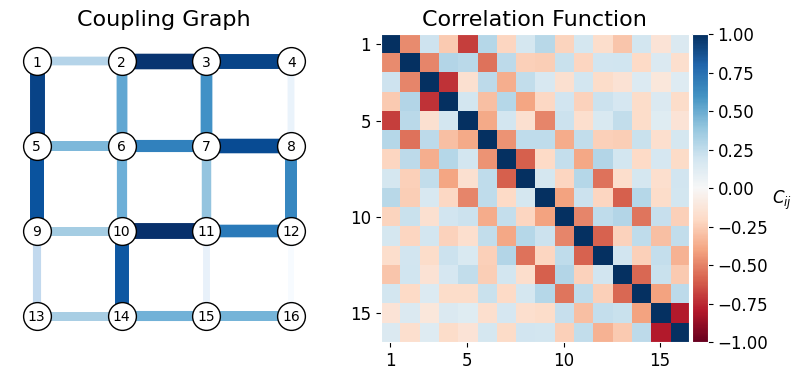

In [11]:
plot_eval_matrix(J, exact_correlation_matrix, title='Correlation Function', cmap='RdBu')

### Computing the exact entanglement entropies

Similar to the correlation functions, we can also compute subsystem entanglement entropies exactly, given the ground state above.

In [12]:
def compute_exact_entropy_matrix(ground_state, wires):
    ground_state_qobj = qutip.Qobj(ground_state, dims=[[2] * wires, [1] * wires])

    # compute entropies
    entropies = np.zeros(shape=(wires, wires), dtype=float)
    for i in tqdm(range(wires)):
        ptrace_diag = ground_state_qobj.ptrace(sel=[i])
        entropies[i, i] = -np.log(np.trace(ptrace_diag * ptrace_diag).real)

        for j in range(i + 1, wires):
            ptrace = ground_state_qobj.ptrace(sel=[i, j])
            e = -np.log(np.trace(ptrace * ptrace).real)
            entropies[i, j] = entropies[j, i] = e

    return entropies

In [13]:
exact_entropy_matrix = compute_exact_entropy_matrix(ground_state, wires)

100%|██████████| 16/16 [00:00<00:00, 107.38it/s]


In [ ]:
plot_eval_matrix(J, exact_entropy_matrix, title='Subsystem Entanglement Entropies', cmap='Blues', vmin=0.0, vmax=None)

# Making predictions using a conditional transformer model

In [1]:
from jax import jit
import jax.numpy as jnp

from heisenberg_tutorial.transformer import initialize, preprocess_coupling_matrix

ModuleNotFoundError: jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.

Here, we use a conditional transformer model to predict 2-point correlations and subsystem entanglement entropies for the ground state of the 2D anti-ferromagnetic Heisenberg model. Our model consists of an encoder $g_\phi\colon \mathcal{G} \to \mathbb{R}^d$, that encodes the coupling graph into a latent representation $G \mapsto g_\phi(G)$. The encoding $g_\phi$ is parametrized as a graph convolutional neural network (GCNN), a particular type of neural network that is capable of processing graph-structured data. This representation is then fed into a transformer network, making use of a self-attention mechanism, allowing the model to learn long-distance correlations between pairs of qubits. The following is an illustration of the architecture of our generative model:

<div align="center">
<img src="resources/figures/tutorial-transformer.png" width="400"/>
</div>

In this section we will use a model which has already been trained on a dataset with samples of ground states of 80 random Hamiltonians. For this trained model, we generate new samples in an autorgressive manner, making use of the decomposition

$$
     p_{\theta,\phi}(a_1,\,\ldots,\,a_n~\lvert~\mathbf{x}) = \prod_{i=1}^n p_\theta(a_i~\lvert~a_{i-1},\,\ldots,\,a_1,\, g_\phi(\mathbf{x})).
$$

Let us first initialize the generative model

In [14]:
# initialize transformer
transformer = initialize()

# process coupling matrix
coupling_graph = preprocess_coupling_matrix(J)

Now, we can generate a number of samples which we will use to estimate properties of the ground state. Note that generating these 10'000 takes around 2 minutes.

In [15]:
# sample from model
samples = transformer.sample(
    samples=10000, coupling_graph=coupling_graph, qubits=wires, batch_size=1000, print_progress=False
)

Let us have a quick look at a few samples which our model has generated:

In [16]:
print(samples[:5])

[[5 2 4 0 1 3 0 1 0 4 0 1 0 5 1 4]
 [2 0 0 2 0 4 5 3 4 0 3 2 5 4 1 4]
 [0 0 5 4 3 1 0 5 3 4 3 1 2 0 0 5]
 [4 4 5 0 1 5 4 3 0 4 5 0 2 0 1 3]
 [4 2 1 2 3 1 5 1 2 3 0 0 2 3 2 1]]


Each row in this array corresponds to a particular realization of measuring the Pauli-6 POVM. The encoding we have used here corresponds to the following mapping:

$$
\begin{aligned}
    +,~- &\mapsto 0, 1 ~~~~ \text{Pauli-X Basis}\\
    r,~l &\mapsto 2, 3 ~~~~ \text{Pauli-Y Basis}\\
    0,~1 &\mapsto 4, 5 ~~~~ \text{Pauli-Z Basis}
\end{aligned}
$$


To construct a classical shadow from this string of measurements, we convert it to two numpy arrays; the first contains the binary measurement outcomes, and the second contains the bases in which the qubits were measured:

### Predicting Properties using Classical Shadows

Given our model, we can sample from it and generate a shadow state, based on which we compute entanglement entropies and correlation functions. In the following, we use the classical shadow implementation from PennyLane to predict these properties.

In [17]:
# splits samples into bits (i.e., measurement outcomes) and recipes (measurement bases)
recipes = samples // 2
bits = samples - 2 * recipes

# instantiate classical shadow
shadow = qml.ClassicalShadow(bits=bits, recipes=recipes)

The following function uses jax to compute entanglement entropies based on the classical shadow:

In [18]:
@jit
def _jax_compute_size_one_entropies(x):
    return -jnp.log(jnp.einsum('timl,silm->i', x, x))

@jit
def _jax_compute_size_two_entropies(x):
    return -jnp.log(jnp.einsum('tilm,siml,tjrk,sjkr->ij', x, x, x, x))

def compute_entropies_from_shadow(shadow):
    """
    compute second-order Rényi entanglement entropies for all subsystems of size at most two, using the classical shadow
    protocol
    """
    local_snapshots = shadow.local_snapshots()
    shadow_size = shadow.snapshots

    # compute size two entropies
    entropies = np.array(_jax_compute_size_two_entropies(local_snapshots) + 2 * np.log(shadow_size))

    # compute size one entropies
    entropies_size_one = np.array(_jax_compute_size_one_entropies(local_snapshots) + 2 * np.log(shadow_size))
    np.fill_diagonal(entropies, entropies_size_one)

    return entropies.real

In [19]:
predicted_entropy_matrix = compute_entropies_from_shadow(shadow=shadow)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [20]:
plot_eval_matrix(
    J, predicted_entropy_matrix, true_mat=exact_entropy_matrix, title='Model Prediction', cmap='Blues', vmin=0.0, vmax=None
)

NameError: name 'exact_entropy_matrix' is not defined

We can also estimate the correlation matrix with our classical shadow.

In [21]:
def compute_correlation_matrix_from_shadow(shadow):
    wires = shadow.bits.shape[1]

    qubit_pairs = list(it.combinations(range(wires), r=2))

    correlations = np.zeros((wires, wires))
    np.fill_diagonal(correlations, 1.0)

    for idx, (i, j) in enumerate(qubit_pairs):
        obs = qml.PauliX(i) @ qml.PauliX(j) + qml.PauliY(i) @ qml.PauliY(j) + qml.PauliZ(i) @ qml.PauliZ(j)
        correlations[i, j] = correlations[j, i] = shadow.expval(H=obs, k=1) / 3

    return correlations

In [22]:
predicted_correlation_matrix = compute_correlation_matrix_from_shadow(shadow=shadow)

/tmp/ipykernel_1162351/866085114.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(eval_mat, cmap=plt.cm.get_cmap(cmap), vmin=vmin, vmax=vmax)
/tmp/ipykernel_1162351/866085114.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(true_mat, cmap=plt.cm.get_cmap(cmap), vmin=vmin, vmax=vmax)


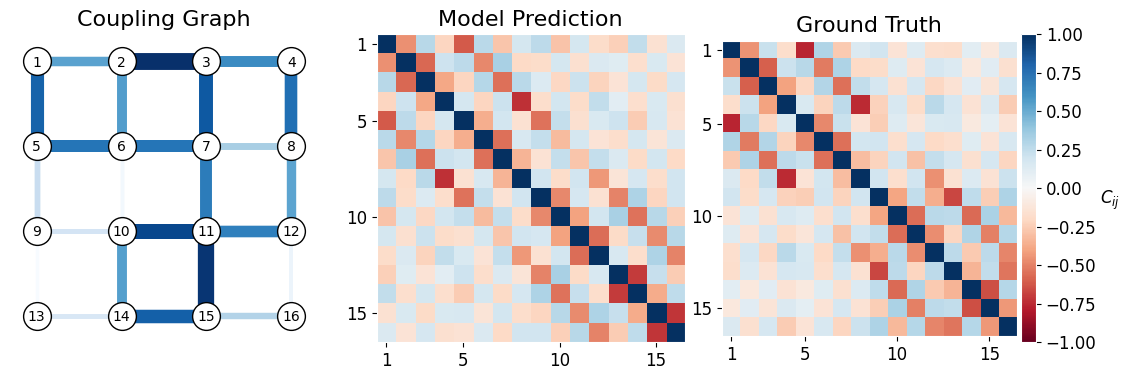

In [23]:
plot_eval_matrix(
    J, predicted_correlation_matrix, true_mat=exact_correlation_matrix, title='Model Prediction', cmap='RdBu'
)

# Training a transformer for a single Hamiltonian

We have seen how a trained conditional generative model can be used to make predictions about different quantum states. Here we will go through the training process and train a transformer on measurements. To train a full-fledged conditional generative model on a big enough number of ground states one needs access to GPUs and -- even then -- training the model to convergence takes around 2 hours of GPU time. For this reason, here we will train a model on a single Hamiltonian as this can be done in reasonable time on a modern laptop.

In [24]:
import seaborn as sns
import torch
import torch.nn as nn
from torch_geometric.data import Data as GraphData
from torch_geometric.data import Batch as GraphBatch

from src.models.graph_encoder import get_graph_encoder
from src.models.gctransformer import init_gctransformer, get_sample_structure

Let us first collect measurements from the above ground state. We do this by making measurements in random Pauli bases, as it is done in the classical shadow protocol.

In [25]:
def generate_pauli6_samples(statevector, wires, shots, device_name='default.qubit'):
    """ generate samples from the Pauli-6 POVM. The resulting samples are encoded as integers according to
    the rules
    0,1 -> +,- in the X Basis
    2,3 -> r,l in the Y Basis
    4,5 -> 0,1 in the Z Bassi
    """
    @qml.qnode(device=qml.device(device_name, wires=wires, shots=shots), diff_method=None, interface=None)
    def shadow_measurement():
        qml.QubitStateVector(statevector, wires=range(wires))
        return qml.classical_shadow(wires=range(wires))

    bits, recipes = shadow_measurement()

    # encode measurements and bases as integers
    data = 2 * recipes + bits
    data = np.array(data, dtype=int)

    return data

In [26]:
# generate data
train_samples = 1000
measurements = generate_pauli6_samples(ground_state, wires=wires, shots=train_samples)

# next, we bring the measurements into the format expected by the transformer 
measurements = measurements + 1
measurements = np.concatenate([0 * np.ones(shape=(train_samples, 1)), measurements], axis=1)
measurements = measurements.astype(int)

# convert measurements to torch tensor
measurements_tensor = torch.from_numpy(measurements)

#### Setting up the generative model
Now, we setup our conditional generative model, consisting of a graph encoder and a transformer. We use a graph encoder with 3 layers and final node dimension 16:

In [27]:
graph_encoder = get_graph_encoder(
        'gcn_proj_3_16', in_node_dim=wires, gcn_dim=16, gcn_layers=3, d_model=128, qubits=wires
    )

Next, we intialize the transformer, consisting of 4 layers, model dimension 128 and 4 attention heads in each self-attention module.

In [43]:
transformer = init_gctransformer(
        n_outcomes=6, # Number of distinct Pauli-6 measurements
        encoder=graph_encoder,
        n_layers=4, # number of sublayers
        d_model=128, # hidden dimension
        d_ff=4 * 128, # number of hidden units in the fully connected layers
        n_heads=4, # number of attention heads
        dropout=0.0,
        pad_token=-1, # no padding
        start_token=0, # start token marks the beginning of a sequence
        end_token=-1, # no end token in alphabet
        token_shift=1 # shift tokens by 1 to account for the start token
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer.to(device)
measurements_tensor = measurements_tensor.to(device)

In the next step, we normalize the coupling matrix and convert it into a graph structure that can be fed to the graph encoder using the `pytorch_geometric` libary.

In [53]:
# normalize
cmax = np.max(J, axis=(0, 1)).reshape((1, 1))
cmin = np.min(J, axis=(0, 1)).reshape((1, 1))
J_normalized = (J - cmin) / (cmax - cmin)

coupling_matrices = [J_normalized for _ in range(train_samples)]

# setup edge indices
graphs_edge_indices = [
    [
        [(i, j), (j, i)] for i, j in it.combinations(range(wires), 2) if mat[i, j] != 0.0
    ] for mat in coupling_matrices
]

# write graph edge weights to torch tensor in COO format and convert to tensor
graphs_edge_weights = [
    torch.from_numpy(np.array([mat[i, j] for i, j in edges], dtype=np.float32).flatten()).to(device)
    for edges, mat in zip(graphs_edge_indices, coupling_matrices)
]

# convert to tensor in COO format for torch_geometric
graphs_edge_indices = [
    torch.from_numpy(np.array([x for x in it.chain(*edge_indices)]).T).to(device)
    for edge_indices in graphs_edge_indices
]


graphs_list = [GraphData(
    x=torch.eye(wires, dtype=torch.float32).to(device), 
    edge_index=edges, edge_weight=weights
) for edges, weights in zip(graphs_edge_indices, graphs_edge_weights)]

Now that we have our training data ready, let su create an iterator that allows us to loop through the data in batches:

In [54]:
class TgtBatch:
    """ object for holding a batch of data with mask """
    def __init__(self, tgt, pad):
        self.tgt = tgt[:, :-1]
        self.tgt_y = tgt[:, 1:]
        self.tgt_mask = make_std_mask(self.tgt, pad)
        self.ntokens = (self.tgt_y != pad).data.sum()  # noqa
        
def subsequent_mask(size):
    """ mask out subsequent positions """
    attn_shape = (1, size, size)
    mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return mask == 0


def make_std_mask(tgt, pad):
    """ Create a mask to hide padding and future words. """
    tgt_mask = (tgt != pad).unsqueeze(-2)  # noqa
    tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
    return tgt_mask


def batch_iterator(data, graphs_list, iterations, batch_size, shuffle=True):
    for step in range(1, iterations + 1):
        # shuffle data
        indices = rng.choice(len(data), batch_size, replace=True)
        tgt_batch = TgtBatch(data[indices], pad=-1)
        graphs_batch = GraphBatch.from_data_list(data_list=[graphs_list[i] for i in indices])
        
        yield tgt_batch, graphs_batch

Next, we set up the KL-divergence loss function. This loss function is more general than the standard KL divergence loss functions as it allows for padding token which are ignored.

In [55]:
class KLDivLoss(nn.Module):
    def __init__(self, padding_idx):
        super(KLDivLoss, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx

    def forward(self, x: torch.Tensor, target: torch.Tensor):
        target_onehot = torch.zeros_like(x)
        target_onehot.scatter_(1, target.unsqueeze(1), 1.0)

        if self.padding_idx >= 0:
            target_onehot[:, self.padding_idx] = 0

        mask = torch.nonzero(target.data == self.padding_idx)  # noqa

        if mask.dim() > 0:
            target_onehot.index_fill_(0, mask.squeeze(), 0.0)

        loss = self.criterion(x, target_onehot)
        return loss
    
criterion = KLDivLoss(padding_idx=-1)

Finally, we also need an optimizer and a learning rate scheduler. We use the AdamW optimizer (which optionally would allow for weight decay regularization, in contrast to the standard Adam optimizer), and a cosine annealing scheduler to decay the learning rate.

In [56]:
total_steps = 2000
optimizer = torch.optim.AdamW(transformer.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-7)

We can now start training our model, using the batch iterator we have setup above.

In [57]:
pbar = tqdm(
    enumerate(batch_iterator(measurements_tensor, graphs_list, iterations=total_steps, batch_size=100)),
    total=total_steps
)

# set transformer to train mode
transformer.train()

losses = []

# iterate over data
for step, (tgt_batch, graphs_batch) in pbar:
    graph_embed, out = transformer.forward(tgt_batch.tgt, tgt_batch.tgt_mask, coupling_graph=graphs_batch)
    log_probs = transformer.generator(out)
    
    total_loss = criterion(
        log_probs.contiguous().view(-1, log_probs.size(-1)), tgt_batch.tgt_y.contiguous().view(-1)
    ) / tgt_batch.ntokens.item()

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    scheduler.step()
    
    # record loss
    losses.append(total_loss.item())
    
    pbar.set_postfix_str(f'[{step+1}/{total_steps}] loss: {total_loss.item():.6f}, lr: {scheduler.get_last_lr()[0]:.6f}')

100%|██████████| 2000/2000 [01:36<00:00, 20.74it/s, [2000/2000] loss: 0.440417, lr: 0.000000]


Now that we have trained our model, let us first visualize the loss.

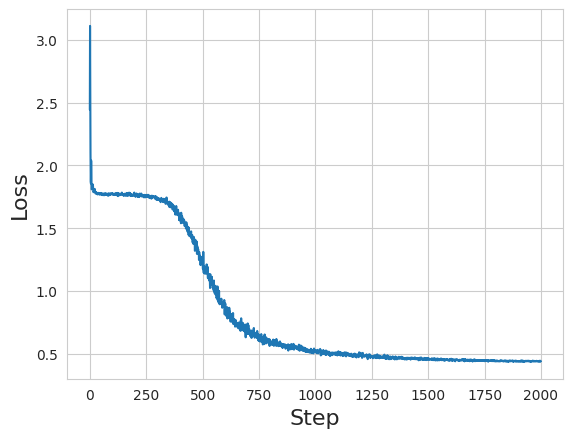

In [58]:
sns.set_style('whitegrid')
plt.plot(np.arange(total_steps), losses);
plt.xlabel('Step', fontsize=16);
plt.ylabel('Loss', fontsize=16);

Next, let us use the model the generate a number of samples which we can use to predict the correlation function and entanglement entropies.

In [59]:
samples = transformer.sample(
    samples=10000, coupling_graph=coupling_graph, qubits=wires, batch_size=1000, print_progress=False
)

# splits sampels into measurement outcomes and bases
recipes = samples // 2
bits = samples - 2 * recipes

In [60]:
# instantiate shadow
shadow = qml.ClassicalShadow(bits=bits, recipes=recipes)

In [61]:
# compute renyi-2 entropies using classical shadow
model_entropy_matrix = compute_entropies_from_shadow(shadow=shadow)

In [62]:
sns.set_style('white')
plot_eval_matrix(
    J, model_entropy_matrix, true_mat=exact_entropy_matrix, title='Model Prediction', cmap='Blues', vmin=0.0, vmax=None
)

NameError: name 'exact_entropy_matrix' is not defined

In [63]:
# compute correlation matrix using classical shadow
model_correlation_matrix = compute_correlation_matrix_from_shadow(shadow=shadow)

/tmp/ipykernel_1162351/866085114.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(eval_mat, cmap=plt.cm.get_cmap(cmap), vmin=vmin, vmax=vmax)
/tmp/ipykernel_1162351/866085114.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(true_mat, cmap=plt.cm.get_cmap(cmap), vmin=vmin, vmax=vmax)


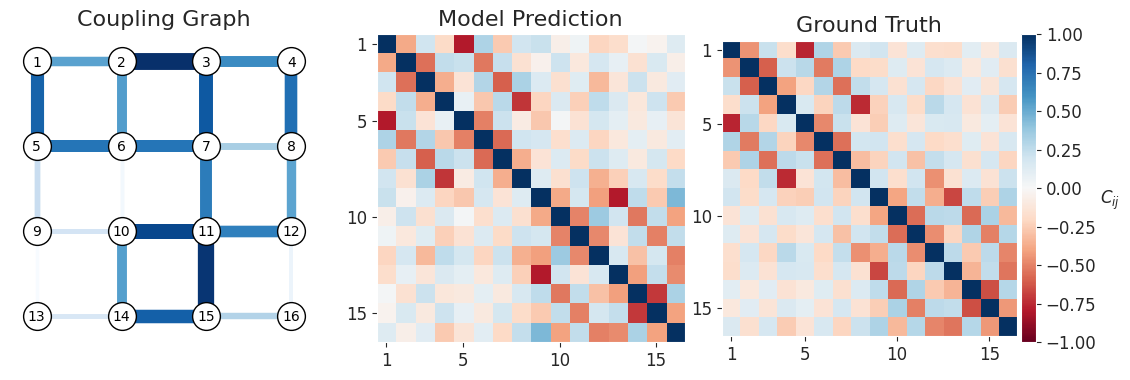

In [64]:
sns.set_style('white')
plot_eval_matrix(
    J, model_correlation_matrix, true_mat=exact_correlation_matrix, title='Model Prediction', cmap='RdBu'
)